In [ ]:
# Importing Libraries
import librosa  
import numpy as np  
import os
import tensorflow as tf
from tqdm import tqdm


In [ ]:

# Utliity Functions
def extract_features(audio_path):
    data, sr = librosa.load(audio_path, res_type='kaiser_fast')
    mfccs = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=64)
    mfccs = np.mean(mfccs.T, axis=0)
    return mfccs


In [ ]:
# Defining features and labels
X = []
Y = []
base_dir = os.getcwd()
dataset_dir = os.path.join(base_dir, 'filtered_dataset')
emotions = ['Neutral', 'Happy', 'Sad', 'Angry', 'Fearful', 'Disgusted', 'Surprised']  

In [ ]:
# Extracting features
total_files = sum([len(files) for r, d, files in os.walk(dataset_dir)])
pbar = tqdm(total=total_files)

for emotion in emotions:
    emotion_dir = os.path.join(dataset_dir, emotion)
    for file in os.listdir(emotion_dir):
        if file.endswith('.wav'):
            audio_path = os.path.join(emotion_dir, file)
            features = extract_features(audio_path)
            X.append(features)
            Y.append(emotion)
            pbar.update()

pbar.close()

In [ ]:
# Saving Features and Labels
np.save('saved_features/data.npy', X)
np.save('saved_features/labels.npy', Y)

In [ ]:

# Importing saved features
X = np.load('saved_features/data.npy')
Y = np.load('saved_features/labels.npy')

# Converting to numpy arrays
X = np.array(X)
Y = np.array(Y)

# Label Encoding
from sklearn.preprocessing import LabelEncoder
lr = LabelEncoder()
Y_enc = lr.fit_transform(Y)

# Splitting the data
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_enc, test_size=0.3, random_state=48)   


In [ ]:
# Checking the encoded labels
for index, label in enumerate(lr.classes_):
    print(f'{index}: {label}')

In [ ]:

# Building the model
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    Input(shape=(X_train.shape[1], 1)),
    Conv1D(64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    Conv1D(128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    Conv1D(256, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    Flatten(),
    
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(7, activation='softmax')
])


In [ ]:

# Compiling the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Defining the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=14, verbose=1)

In [12]:

# Train the model
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size=32, callbacks=[early_stopping])

Epoch 1/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.3296 - loss: 2.1273 - val_accuracy: 0.3944 - val_loss: 1.5338
Epoch 2/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4835 - loss: 1.3770 - val_accuracy: 0.5691 - val_loss: 1.1056
Epoch 3/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5223 - loss: 1.2397 - val_accuracy: 0.5894 - val_loss: 1.0623
Epoch 4/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5426 - loss: 1.2046 - val_accuracy: 0.5961 - val_loss: 1.0308
Epoch 5/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5615 - loss: 1.1259 - val_accuracy: 0.6275 - val_loss: 0.9699
Epoch 6/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5705 - loss: 1.0954 - val_accuracy: 0.6255 - val_loss: 0.9736
Epoch 7/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5822 - loss: 1.0768 - val_accuracy: 0.6434 - val_loss: 0.9365
Epoch 8/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5979 - loss: 1.0411 - 

In [13]:
# Evaluating the model
model.evaluate(X_test, Y_test)

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6761 - loss: 0.8322


[0.8475584983825684, 0.683876097202301]

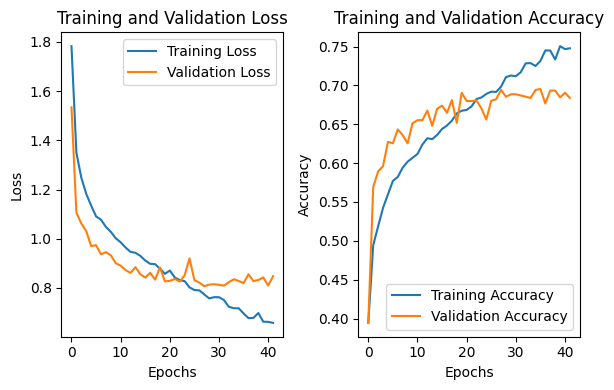

In [15]:
# Visualizing the training history
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4))

# Plot training loss and validation loss
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()

# Plot training accuracy and validation accuracy
ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

In [20]:
# Saving the model
model.save('saved_model/model.keras')